In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import re
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

## Configuration

In [2]:
class config:
    
    model_name = "google-t5/t5-small"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
   
    root = "/kaggle/input/llm-hw2-1data"
    batch_size = 4
    lr = 1e-4
    epochs = 100
    weight_decay = 1e-3
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device:', config.device)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

device: cuda


## Input data

In [3]:
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
validation_data = pd.read_csv(os.path.join(config.root, 'validation.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'))

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of validation samples: {validation_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

Number of training samples: 2871
Number of validation samples: 134
Number of testing samples: 115


## Define functions

In [4]:
def seed_everything(seed):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_one_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Training Loss: {avg_loss:.4f}")
    return avg_loss

def validate(model, valid_loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(valid_loader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss


In [5]:
def preprocess_text(text):
   # Convert to lowercase
   text = text.lower()
   
   # Remove punctuation and special characters
   text = re.sub(r'[^\w\s]', '', text)
   
   # Remove extra whitespace and trim
   text = ' '.join(text.split())
   
   return text

In [6]:
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, tokenizer, 
                 max_input_length=1024, max_target_length=64,
                 preprocess_fun=None):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.preprocess_fun = preprocess_fun
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        if self.preprocess_fun:
            input_text = self.preprocess_fun(input_text)
            target_text = self.preprocess_fun(target_text)
        
        # Tokenize the input paragraph
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Tokenize the target summary
        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": target_encoding["input_ids"].squeeze()
        }


## Early stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, save_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_val_loss = float('inf')
        self.early_stop = False
        self.save_path = save_path
        
    def __call__(self, valid_loss, model):
        if valid_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = valid_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.best_val_loss

## 1. (a) Plot the learning curves for training and validation losses of training data during  training. (15%)

Initializing model...


100%|██████████| 718/718 [04:23<00:00,  2.73it/s]


Training Loss: 3.5714


100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Validation Loss: 2.2608
Epoch 1/100:
Train Loss: 3.5714, Valid Loss: 2.2608
Best Valid Loss: 2.2608


100%|██████████| 718/718 [04:31<00:00,  2.64it/s]


Training Loss: 2.4657


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 2.0431
Epoch 2/100:
Train Loss: 2.4657, Valid Loss: 2.0431
Best Valid Loss: 2.0431


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.3572


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 1.9975
Epoch 3/100:
Train Loss: 2.3572, Valid Loss: 1.9975
Best Valid Loss: 1.9975


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.2902


100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Validation Loss: 1.9613
Epoch 4/100:
Train Loss: 2.2902, Valid Loss: 1.9613
Best Valid Loss: 1.9613


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.2380


100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Validation Loss: 1.9335
Epoch 5/100:
Train Loss: 2.2380, Valid Loss: 1.9335
Best Valid Loss: 1.9335


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.1794


100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Validation Loss: 1.9112
Epoch 6/100:
Train Loss: 2.1794, Valid Loss: 1.9112
Best Valid Loss: 1.9112


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.1384


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8883
Epoch 7/100:
Train Loss: 2.1384, Valid Loss: 1.8883
Best Valid Loss: 1.8883


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.0901


100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Validation Loss: 1.8741
Epoch 8/100:
Train Loss: 2.0901, Valid Loss: 1.8741
Best Valid Loss: 1.8741


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.0627


100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Validation Loss: 1.8619
Epoch 9/100:
Train Loss: 2.0627, Valid Loss: 1.8619
Best Valid Loss: 1.8619


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.0291


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 1.8529
Epoch 10/100:
Train Loss: 2.0291, Valid Loss: 1.8529
Best Valid Loss: 1.8529


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 2.0111


100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Validation Loss: 1.8407
Epoch 11/100:
Train Loss: 2.0111, Valid Loss: 1.8407
Best Valid Loss: 1.8407


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9926


100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Validation Loss: 1.8357
Epoch 12/100:
Train Loss: 1.9926, Valid Loss: 1.8357
Best Valid Loss: 1.8357


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9849


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8317
Epoch 13/100:
Train Loss: 1.9849, Valid Loss: 1.8317
Best Valid Loss: 1.8317


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9681


100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Validation Loss: 1.8261
Epoch 14/100:
Train Loss: 1.9681, Valid Loss: 1.8261
Best Valid Loss: 1.8261


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9636


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8215
Epoch 15/100:
Train Loss: 1.9636, Valid Loss: 1.8215
Best Valid Loss: 1.8215


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9494


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 1.8182
Epoch 16/100:
Train Loss: 1.9494, Valid Loss: 1.8182
Best Valid Loss: 1.8182


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9429


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8166
Epoch 17/100:
Train Loss: 1.9429, Valid Loss: 1.8166
Best Valid Loss: 1.8166


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9395


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8130
Epoch 18/100:
Train Loss: 1.9395, Valid Loss: 1.8130
Best Valid Loss: 1.8130


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9317


100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Validation Loss: 1.8115
Epoch 19/100:
Train Loss: 1.9317, Valid Loss: 1.8115
Best Valid Loss: 1.8115


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9229


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8103
Epoch 20/100:
Train Loss: 1.9229, Valid Loss: 1.8103
Best Valid Loss: 1.8103


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9202


100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Validation Loss: 1.8078
Epoch 21/100:
Train Loss: 1.9202, Valid Loss: 1.8078
Best Valid Loss: 1.8078


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9143


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8085
Epoch 22/100:
Train Loss: 1.9143, Valid Loss: 1.8085
Best Valid Loss: 1.8078


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9096


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 1.8068
Epoch 23/100:
Train Loss: 1.9096, Valid Loss: 1.8068
Best Valid Loss: 1.8068


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9039


100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Validation Loss: 1.8085
Epoch 24/100:
Train Loss: 1.9039, Valid Loss: 1.8085
Best Valid Loss: 1.8068


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.9039


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8060
Epoch 25/100:
Train Loss: 1.9039, Valid Loss: 1.8060
Best Valid Loss: 1.8060


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8976


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8060
Epoch 26/100:
Train Loss: 1.8976, Valid Loss: 1.8060
Best Valid Loss: 1.8060


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8964


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8052
Epoch 27/100:
Train Loss: 1.8964, Valid Loss: 1.8052
Best Valid Loss: 1.8052


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8915


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8047
Epoch 28/100:
Train Loss: 1.8915, Valid Loss: 1.8047
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8894


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Validation Loss: 1.8062
Epoch 29/100:
Train Loss: 1.8894, Valid Loss: 1.8062
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8896


100%|██████████| 34/34 [00:04<00:00,  7.29it/s]


Validation Loss: 1.8051
Epoch 30/100:
Train Loss: 1.8896, Valid Loss: 1.8051
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8880


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8054
Epoch 31/100:
Train Loss: 1.8880, Valid Loss: 1.8054
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8818


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8058
Epoch 32/100:
Train Loss: 1.8818, Valid Loss: 1.8058
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8781


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8082
Epoch 33/100:
Train Loss: 1.8781, Valid Loss: 1.8082
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8777


100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Validation Loss: 1.8080
Epoch 34/100:
Train Loss: 1.8777, Valid Loss: 1.8080
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:31<00:00,  2.64it/s]


Training Loss: 1.8753


100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Validation Loss: 1.8081
Epoch 35/100:
Train Loss: 1.8753, Valid Loss: 1.8081
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8759


100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Validation Loss: 1.8080
Epoch 36/100:
Train Loss: 1.8759, Valid Loss: 1.8080
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8739


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8079
Epoch 37/100:
Train Loss: 1.8739, Valid Loss: 1.8079
Best Valid Loss: 1.8047


100%|██████████| 718/718 [04:32<00:00,  2.64it/s]


Training Loss: 1.8718


100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Validation Loss: 1.8083
Epoch 38/100:
Train Loss: 1.8718, Valid Loss: 1.8083
Best Valid Loss: 1.8047

Early stopping triggered at epoch 38
Best validation loss: 1.8047


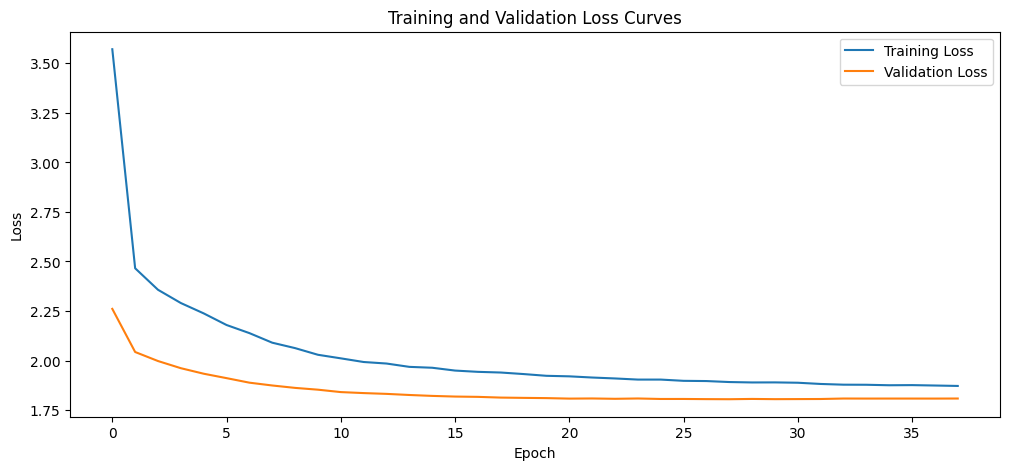

In [8]:
def main():
    # Assuming you have a config object with necessary attributes
    seed_everything(config.seed)
    
    # Load datasets
    train_dataset = pd.read_csv(os.path.join(config.root, 'train.csv'))
    validation_dataset = pd.read_csv(os.path.join(config.root, 'validation.csv'))
    
    # Prepare inputs and targets
    train_inputs = train_dataset['article'].tolist()
    train_targets = train_dataset['highlights'].tolist()
    val_inputs = validation_dataset['article'].tolist()
    val_targets = validation_dataset['highlights'].tolist()
    
    # Create dataset objects
    train_dataset = SummarizationDataset(
        inputs=train_inputs, 
        targets=train_targets, 
        tokenizer=config.tokenizer,
        preprocess_fun=preprocess_text
    )
    val_dataset = SummarizationDataset(
        inputs=val_inputs, 
        targets=val_targets, 
        tokenizer=config.tokenizer,
        preprocess_fun=preprocess_text
    )
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False
    )
    
    print("Initializing model...")
    model = config.model  # Replace with your actual model initialization
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss().to(config.device)
    
    parameters = [p for p in model.parameters() if p.requires_grad]
    
    # Optimizer and Scheduler
    optimizer = torch.optim.Adam(
        parameters, 
        lr=config.lr, 
        weight_decay=config.weight_decay
    ) 
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        epochs=config.epochs,
        steps_per_epoch=len(train_loader),
        max_lr=config.lr,
        anneal_strategy='cos'
    )
    
    early_stopping = EarlyStopping(patience=10, save_path='best_model.pt')

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.1
    )
    
    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
        "best_val_loss": []
    }

    for epoch in range(config.epochs):
        # Training
        train_loss = train_one_epoch(
            model, train_loader, optimizer, 
            config.device, criterion
        )
        
        # Validation
        valid_loss = validate(
            model, val_loader, 
            config.device, criterion
        )

        history["train"]["loss"].append(train_loss)
        history["valid"]["loss"].append(valid_loss)

        best_val_loss = early_stopping(valid_loss, model)
        history["best_val_loss"].append(best_val_loss)

        scheduler.step(valid_loss)
        
        print(f'Epoch {epoch+1}/{config.epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
        print(f'Best Valid Loss: {best_val_loss:.4f}')
    
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break
        
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(history["train"]["loss"], label='Training Loss')
    plt.plot(history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

if __name__ == "__main__":
    main()

## ROGUE

In [9]:
import re
import torch
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [10]:
def get_ngrams(text, n):
   """Convert text into word n-grams."""
   words = text.split()
   ngrams = []
   for i in range(len(words) - n + 1):
       ngram = ' '.join(words[i:i + n])
       ngrams.append(ngram)
   return ngrams

def calculate_rouge_n(reference, candidate, n):
   """Calculate ROUGE-N score."""
   # Get n-grams
   ref_ngrams = Counter(get_ngrams(reference, n))
   cand_ngrams = Counter(get_ngrams(candidate, n))
   
   # Find common n-grams
   common_ngrams = sum((ref_ngrams & cand_ngrams).values())
   
   # Calculate precision and recall
   if sum(cand_ngrams.values()) == 0:
       precision = 0
   else:
       precision = common_ngrams / sum(cand_ngrams.values())
       
   if sum(ref_ngrams.values()) == 0:
       recall = 0
   else:
       recall = common_ngrams / sum(ref_ngrams.values())
   
   # Calculate F1 score
   if precision + recall == 0:
       f1_score = 0
   else:
       f1_score = 2 * (precision * recall) / (precision + recall)
   
   return {
       'precision': precision,
       'recall': recall,
       'f1_score': f1_score
   }

def calculate_rouge_l(reference, candidate):
   def lcs(X, Y):
       m, n = len(X), len(Y)
       L = [[0] * (n + 1) for _ in range(m + 1)]

       for i in range(1, m + 1):
           for j in range(1, n + 1):
               if X[i-1] == Y[j-1]:
                   L[i][j] = L[i-1][j-1] + 1
               else:
                   L[i][j] = max(L[i-1][j], L[i][j-1])
       return L[m][n]

   ref_words = reference.split()
   cand_words = candidate.split()
   
   lcs_length = lcs(ref_words, cand_words)
   
   if len(cand_words) == 0:
       precision = 0
   else:
       precision = lcs_length / len(cand_words)
       
   if len(ref_words) == 0:
       recall = 0
   else:
       recall = lcs_length / len(ref_words)
   
   if precision + recall == 0:
       f1_score = 0
   else:
       f1_score = 2 * (precision * recall) / (precision + recall)
   
   return {
       'precision': precision,
       'recall': recall,
       'f1_score': f1_score
   }

def evaluate_summaries(reference, candidate):
   rouge1 = calculate_rouge_n(reference, candidate, 1)
   rouge2 = calculate_rouge_n(reference, candidate, 2)
   rougeL = calculate_rouge_l(reference, candidate)
   
   return {
       'rouge1': rouge1,
       'rouge2': rouge2,
       'rougeL': rougeL
   }

In [11]:
def generate_summary(model, text, tokenizer, device, max_length=150):
    
    model.eval()
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        try:
            generated_ids = model.generate(
                **inputs,
                min_length=60,
                max_length=150,
                num_beams=8,
                length_penalty=1.5,
                no_repeat_ngram_size=2,
                early_stopping=False
            )

            generated_ids = generated_ids.cpu()
            summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            return summary
        except RuntimeError as e:
            print(f"Error generating summary: {e}")
            return ""

def evaluate_test_set(model, test_df, tokenizer, device):

    model = model.to(device)
    
    results = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        try:
            # Generate summary
            generated_summary = generate_summary(
                model=model,
                text=row['article'],
                tokenizer=tokenizer,
                device=device
            )
            
          
            processed_reference = preprocess_text(row['highlights'])
            processed_generated = preprocess_text(generated_summary)
            
            scores = evaluate_summaries(processed_reference, processed_generated)
            
            # Store results
            results.append({
                'article_id': idx,
                'original_generated': generated_summary,
                'original_reference': row['highlights'],
                'processed_generated': processed_generated,
                'processed_reference': processed_reference,
                'rouge1_f': scores['rouge1']['f1_score'],
                'rouge2_f': scores['rouge2']['f1_score'],
                'rougeL_f': scores['rougeL']['f1_score']
            })
            
        except Exception as e:
            print(f"Error processing article {idx}: {str(e)}")
            # Add error record
            results.append({
                'article_id': idx,
                'error': str(e),
                'rouge1_f': None,
                'rouge2_f': None,
                'rougeL_f': None
            })
    
    return pd.DataFrame(results)

def run_evaluation(config):
    try:
        config.model = config.model.to(config.device)
        
        results_df = evaluate_test_set(
            model=config.model,
            test_df=test_df,
            tokenizer=config.tokenizer,
            device=config.device
        )
        
        return results_df
        
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return None

## 1. (b) Please implement the functions for ROUGE-1 and ROUGE-2 to evaluate the model  performance on the test.csv dataset (5%).

執行結果如下面的程式碼所示，ROGUE分數為

Average ROUGE scores:

ROUGE-1: 0.3683

ROUGE-2: 0.1506

## 1. (c) Similarly, write a function to calculate ROUGE-L to evaluate the model results. Compare the results of ROUGE-L with those of the ROUGE-1 and ROUGE-2, and make some discussion. (5%)

In [12]:
test_df = pd.DataFrame(test_data)
results_df = run_evaluation(config)

# Print average scores
print("\nAverage ROUGE scores:")
print(f"ROUGE-1: {results_df['rouge1_f'].mean():.4f}")
print(f"ROUGE-2: {results_df['rouge2_f'].mean():.4f}")
print(f"ROUGE-L: {results_df['rougeL_f'].mean():.4f}")

# Save detailed results
results_df.to_csv('test_results_with_finetune.csv', index=False)

# Display some examples
print("\nExample Comparisons:")
for i in range(min(3, len(results_df))):
    print(f"\nExample {i+1}:")
    print("Original Generated:", results_df.iloc[i]['original_generated'])
    print("Original Reference:", results_df.iloc[i]['original_reference'])
    print("Processed Generated:", results_df.iloc[i]['processed_generated'])
    print("Processed Reference:", results_df.iloc[i]['processed_reference'])
    print(f"ROUGE-1 F1: {results_df.iloc[i]['rouge1_f']:.4f}")
    print(f"ROUGE-2 F1: {results_df.iloc[i]['rouge2_f']:.4f}")
    print(f"ROUGE-L F1: {results_df.iloc[i]['rougeL_f']:.4f}")
    print("-" * 80)


Evaluating: 100%|██████████| 115/115 [02:01<00:00,  1.05s/it]


Average ROUGE scores:
ROUGE-1: 0.3683
ROUGE-2: 0.1506
ROUGE-L: 0.2538

Example Comparisons:

Example 1:
Original Generated: Dr Zoe Waller, 31, suffers from dermatographia, a type of urticaria, or hives - where raised, itchy rash appears on the skin at the slightest pressure. it is thought to be caused when cells under the surface release histamines as part of an allergic reaction causing skin to swell
Original Reference: Zoe Waller, 31, has dermatographia and can draw designs on her own body .
Condition is a type of urticaria - where an itchy rash appears after pressure .
She says it 'doesn't hurt' and draws molecules on herself to teach students .
Has become  famous across her university and people now make requests .
Processed Generated: dr zoe waller 31 suffers from dermatographia a type of urticaria or hives where raised itchy rash appears on the skin at the slightest pressure it is thought to be caused when cells under the surface release histamines as part of an allergic reactio

執行結果如上面的程式碼所示，ROUGE-L分數為0.2538，分數介於ROGUE-1與ROGUE-2中間，這個結果與ROGUE分數的計算方式有關，ROGUE-1是找找重複的1-gram，ROGUE-2是找重複的2-gram，自然ROGUE-2就是比較困難的，分數也會比ROGUE-1低，而ROGUE-L是比較最長的共同序列，只要有在一定順序有出現相同的字就可以算，例如作業說明中的Today is a good day.跟Today is wonderful day.，用N-gram的概念來看只有Today is是重疊的，但是以ROGUE-L的標準來看，最長共同序列就是Today is day.。

## 2. Please use the pre-trained Google-T5-small model without any fine-tuning.

In [26]:
test_df = pd.DataFrame(test_data)

def evaluate_test_set(model, test_df, tokenizer, device):

    model = model.to(device)
    
    results = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        try:
            preprocessed_text = preprocess_text(row['article'])
            
            input_text = "summarize: " + preprocessed_text
            
            # Generate summary
            inputs = tokenizer(
                input_text, 
                return_tensors='pt', 
                max_length=512, 
                truncation=True
            ).to(device)
            
            output = model.generate(
                inputs.input_ids, 
                min_length=60, 
                max_length=150,
                num_return_sequences=1
            )
            
            generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
            
            processed_reference = preprocess_text(row['highlights'])
            processed_generated = preprocess_text(generated_summary)
            
            scores = evaluate_summaries(processed_reference, processed_generated)
            
            # Store results
            results.append({
                'article_id': idx,
                'original_generated': generated_summary,
                'original_reference': row['highlights'],
                'processed_generated': processed_generated,
                'processed_reference': processed_reference,
                'rouge1_f': scores['rouge1']['f1_score'],
                'rouge2_f': scores['rouge2']['f1_score'],
                'rougeL_f': scores['rougeL']['f1_score']
            })
            
        except Exception as e:
            print(f"Error processing article {idx}: {str(e)}")
            # Add error record
            results.append({
                'article_id': idx,
                'error': str(e),
                'rouge1_f': None,
                'rouge2_f': None,
                'rougeL_f': None
            })
    
    return pd.DataFrame(results)

results_df = evaluate_test_set(config.model, test_df,
                               config.tokenizer, config.device)

print("\nAverage ROUGE scores:")
print(f"ROUGE-1: {results_df['rouge1_f'].mean():.4f}")
print(f"ROUGE-2: {results_df['rouge2_f'].mean():.4f}")
print(f"ROUGE-L: {results_df['rougeL_f'].mean():.4f}")

results_df.to_csv('test_results_no_finetune.csv', index=False)

# Display some examples
print("\nExample Comparisons:")
for i in range(min(3, len(results_df))):
    print(f"\nExample {i+1}:")
    print("Original Generated:", results_df.iloc[i]['original_generated'])
    print("Original Reference:", results_df.iloc[i]['original_reference'])
    print("Processed Generated:", results_df.iloc[i]['processed_generated'])
    print("Processed Reference:", results_df.iloc[i]['processed_reference'])
    print(f"ROUGE-1 F1: {results_df.iloc[i]['rouge1_f']:.4f}")
    print(f"ROUGE-2 F1: {results_df.iloc[i]['rouge2_f']:.4f}")
    print(f"ROUGE-L F1: {results_df.iloc[i]['rougeL_f']:.4f}")
    print("-" * 80)

Evaluating: 100%|██████████| 115/115 [01:21<00:00,  1.41it/s]


Average ROUGE scores:
ROUGE-1: 0.3694
ROUGE-2: 0.1485
ROUGE-L: 0.2509

Example Comparisons:

Example 1:
Original Generated: dr zoe waller 31 suffers from the skin condition dermatographia a type of urticaria or hives where a raised itchy rash appears on the skin at the slightest pressure it is thought to be caused when cells under the surface of the skin release histamines as part of an allergic reaction causing the skin to swell
Original Reference: Zoe Waller, 31, has dermatographia and can draw designs on her own body .
Condition is a type of urticaria - where an itchy rash appears after pressure .
She says it 'doesn't hurt' and draws molecules on herself to teach students .
Has become  famous across her university and people now make requests .
Processed Generated: dr zoe waller 31 suffers from the skin condition dermatographia a type of urticaria or hives where a raised itchy rash appears on the skin at the slightest pressure it is thought to be caused when cells under the surface

## 3. Please use the model you fine-tuned in the first question, and apply the soft prompt method to enhance the performance of summary tasks.

In [14]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

**這裡有使用在fine-tuning階段訓練好的模型(best_model_1126.pt)，這個檔案會一併上傳到e3，不然的話沒辦法重現結果。**

In [15]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.load_state_dict(torch.load('/kaggle/input/t5-training-result/best_model_1126.pt'))
pretrained_t5 = model

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
class SoftPromptT5(nn.Module):
    def __init__(self, model, prompt_length=10, prompt_dim=512):
        super().__init__()
        self.base_model = model
        
        self.soft_prompt = nn.Parameter(torch.randn(prompt_length, prompt_dim))
        
        for param in self.base_model.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids, attention_mask, labels):
        input_embeds = self.base_model.encoder.embed_tokens(input_ids)
        
        soft_prompt_embeds = self.soft_prompt.unsqueeze(0).expand(input_embeds.size(0), -1, -1)
        modified_input_embeds = torch.cat([soft_prompt_embeds, input_embeds], dim=1)
        
        extended_attention_mask = torch.cat([
            torch.ones(attention_mask.size(0), soft_prompt_embeds.size(1)).to(attention_mask.device), 
            attention_mask
        ], dim=1)
        
        outputs = self.base_model(
            inputs_embeds=modified_input_embeds,
            attention_mask=extended_attention_mask,
            labels=labels
        )
        
        return outputs

In [18]:
def prepare_datasets_and_loaders(config):
    
    train_dataset = pd.read_csv(os.path.join(config.root, 'train.csv'))
    validation_dataset = pd.read_csv(os.path.join(config.root, 'validation.csv'))
    
    train_inputs = train_dataset['article'].tolist()
    train_targets = train_dataset['highlights'].tolist()
    val_inputs = validation_dataset['article'].tolist()
    val_targets = validation_dataset['highlights'].tolist()
    
    train_dataset = SummarizationDataset(
        inputs=train_inputs, 
        targets=train_targets, 
        tokenizer=config.tokenizer,
        preprocess_fun=preprocess_text
    )
    val_dataset = SummarizationDataset(
        inputs=val_inputs, 
        targets=val_targets, 
        tokenizer=config.tokenizer,
        preprocess_fun=preprocess_text
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False
    )
    
    return train_loader, val_loader

## 3. (a) Plot the learning curves for training and validation losses of training data during  training. (15%)

Initializing model...


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 1/100:
Train Loss: 1.9456, Valid Loss: 1.8244
Best Valid Loss: 1.8244


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 2/100:
Train Loss: 1.9222, Valid Loss: 1.8141
Best Valid Loss: 1.8141


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 3/100:
Train Loss: 1.9081, Valid Loss: 1.8109
Best Valid Loss: 1.8109


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 4/100:
Train Loss: 1.9029, Valid Loss: 1.8081
Best Valid Loss: 1.8081


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 5/100:
Train Loss: 1.8976, Valid Loss: 1.8057
Best Valid Loss: 1.8057


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 6/100:
Train Loss: 1.8947, Valid Loss: 1.8045
Best Valid Loss: 1.8045


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 7/100:
Train Loss: 1.8955, Valid Loss: 1.8039
Best Valid Loss: 1.8039


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 8/100:
Train Loss: 1.8935, Valid Loss: 1.8037
Best Valid Loss: 1.8037


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 9/100:
Train Loss: 1.8928, Valid Loss: 1.8032
Best Valid Loss: 1.8032


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 10/100:
Train Loss: 1.8927, Valid Loss: 1.8029
Best Valid Loss: 1.8029


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Epoch 11/100:
Train Loss: 1.8924, Valid Loss: 1.8028
Best Valid Loss: 1.8028


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 12/100:
Train Loss: 1.8920, Valid Loss: 1.8026
Best Valid Loss: 1.8026


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 13/100:
Train Loss: 1.8912, Valid Loss: 1.8023
Best Valid Loss: 1.8023


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 14/100:
Train Loss: 1.8923, Valid Loss: 1.8021
Best Valid Loss: 1.8021


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 15/100:
Train Loss: 1.8916, Valid Loss: 1.8019
Best Valid Loss: 1.8019


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 16/100:
Train Loss: 1.8879, Valid Loss: 1.8018
Best Valid Loss: 1.8018


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 17/100:
Train Loss: 1.8899, Valid Loss: 1.8016
Best Valid Loss: 1.8016


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 18/100:
Train Loss: 1.8920, Valid Loss: 1.8014
Best Valid Loss: 1.8014


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 19/100:
Train Loss: 1.8886, Valid Loss: 1.8012
Best Valid Loss: 1.8012


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 20/100:
Train Loss: 1.8892, Valid Loss: 1.8010
Best Valid Loss: 1.8010


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 21/100:
Train Loss: 1.8880, Valid Loss: 1.8009
Best Valid Loss: 1.8009


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 22/100:
Train Loss: 1.8872, Valid Loss: 1.8008
Best Valid Loss: 1.8008


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 23/100:
Train Loss: 1.8923, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 24/100:
Train Loss: 1.8893, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Epoch 25/100:
Train Loss: 1.8907, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 26/100:
Train Loss: 1.8871, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 27/100:
Train Loss: 1.8873, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 28/100:
Train Loss: 1.8886, Valid Loss: 1.8007
Best Valid Loss: 1.8007


100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Epoch 29/100:
Train Loss: 1.8885, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 30/100:
Train Loss: 1.8901, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 31/100:
Train Loss: 1.8875, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 32/100:
Train Loss: 1.8885, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 33/100:
Train Loss: 1.8879, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 34/100:
Train Loss: 1.8930, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 35/100:
Train Loss: 1.8901, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 36/100:
Train Loss: 1.8894, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 37/100:
Train Loss: 1.8908, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 38/100:
Train Loss: 1.8877, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 39/100:
Train Loss: 1.8864, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 40/100:
Train Loss: 1.8903, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 41/100:
Train Loss: 1.8887, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 42/100:
Train Loss: 1.8887, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 43/100:
Train Loss: 1.8890, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Epoch 44/100:
Train Loss: 1.8920, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 45/100:
Train Loss: 1.8913, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 46/100:
Train Loss: 1.8908, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Epoch 47/100:
Train Loss: 1.8857, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Epoch 48/100:
Train Loss: 1.8910, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 49/100:
Train Loss: 1.8898, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.23it/s]


Epoch 50/100:
Train Loss: 1.8869, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Epoch 51/100:
Train Loss: 1.8869, Valid Loss: 1.8006
Best Valid Loss: 1.8006


100%|██████████| 34/34 [00:05<00:00,  6.26it/s]



Early stopping triggered at epoch 52
Best validation loss: 1.8006


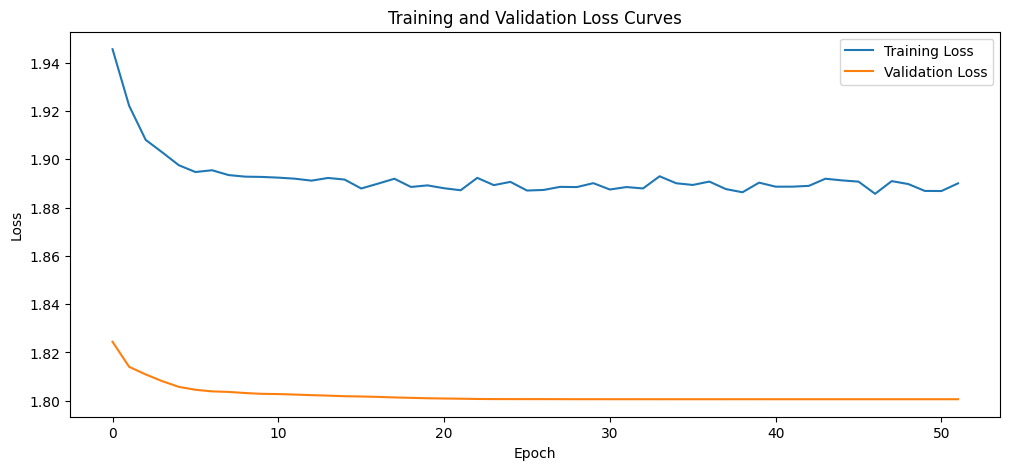

In [19]:
# Training Loop
train_loader, val_loader = prepare_datasets_and_loaders(config)
soft_prompt_model = SoftPromptT5(pretrained_t5)
soft_prompt_model.to(config.device)
optimizer = torch.optim.Adam([soft_prompt_model.soft_prompt], lr=config.lr)
early_stopping = EarlyStopping(patience=10, save_path='best_soft_model.pt')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=5, factor=0.1)
best_val_loss = float('inf')
history = {
        "train": {"loss": []},
        "valid": {"loss": []},
        "best_val_loss": []
    }

print("Initializing model...")
for epoch in range(config.epochs):

    soft_prompt_model.train()
    total_train_loss = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(config.device)
        attention_mask = batch['attention_mask'].to(config.device)
        labels = batch['labels'].to(config.device)
        
        outputs = soft_prompt_model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            labels=labels
        )
        
        train_loss = outputs.loss
        train_loss.backward()
        optimizer.step()
        
        total_train_loss += train_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    history["train"]["loss"].append(avg_train_loss)
    
    soft_prompt_model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            
            input_ids = batch['input_ids'].to(config.device) 
            attention_mask = batch['attention_mask'].to(config.device)
            labels = batch['labels'].to(config.device)
            
            outputs = soft_prompt_model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                labels=labels
            )
            
            valid_loss = outputs.loss
            total_val_loss += valid_loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        history["valid"]["loss"].append(avg_val_loss)
        scheduler.step(avg_val_loss)

        best_val_loss = early_stopping(avg_val_loss, soft_prompt_model)
        history["best_val_loss"].append(best_val_loss)
        scheduler.step(avg_val_loss)

        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}")
            break
    
    print(f'Epoch {epoch+1}/{config.epochs}:')
    print(f'Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}')
    print(f'Best Valid Loss: {best_val_loss:.4f}')
    
# Plotting
plt.figure(figsize=(12, 5))
plt.plot(history["train"]["loss"], label='Training Loss')
plt.plot(history["valid"]["loss"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

In [20]:
def generate_summary(model, text, tokenizer, device, max_length=150):
    model.eval()
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        generated_ids = model.base_model.generate(
            **inputs,
            min_length=80,
            max_length=150,
            num_beams=16,
            length_penalty=2,
            no_repeat_ngram_size=3,
            early_stopping=True
        )
        
        generated_ids = generated_ids.cpu()
        summary = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return summary

In [21]:
def evaluate_test_set(model, test_df, tokenizer, device):

    model = model.to(device)
    
    results = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating"):
        try:
            generated_summary = generate_summary(
                model=model,
                text=row['article'],
                tokenizer=tokenizer,
                device=device
            )
            
            processed_reference = preprocess_text(row['highlights'])
            processed_generated = preprocess_text(generated_summary)
            
            scores = evaluate_summaries(processed_reference, processed_generated)
            
            results.append({
                'article_id': idx,
                'original_generated': generated_summary,
                'original_reference': row['highlights'],
                'processed_generated': processed_generated,
                'processed_reference': processed_reference,
                'rouge1_f': scores['rouge1']['f1_score'],
                'rouge2_f': scores['rouge2']['f1_score'],
                'rougeL_f': scores['rougeL']['f1_score']
            })
            
        except Exception as e:
            print(f"Error processing article {idx}: {str(e)}")
            results.append({
                'article_id': idx,
                'error': str(e),
                'rouge1_f': None,
                'rouge2_f': None,
                'rougeL_f': None
            })
    
    return pd.DataFrame(results)

In [22]:
def run_evaluation(soft_prompt_model, test_df, config):
    try:
        soft_prompt_model = soft_prompt_model.to(config.device)
        
        results_df = evaluate_test_set(
            model=soft_prompt_model,
            test_df=test_df,
            tokenizer=config.tokenizer,
            device=config.device
        )
        
        return results_df
        
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return None

## 3. (b) Evaluate the results using your own implementations of ROUGE-1, ROUGE-2, and  ROUGE-L. (3%)

In [23]:
test_df = pd.DataFrame(test_data)
results_df = run_evaluation(
    soft_prompt_model=soft_prompt_model, 
    test_df=test_df, 
    config=config
)

print("\nAverage ROUGE scores:")
print(f"ROUGE-1: {results_df['rouge1_f'].mean():.4f}")
print(f"ROUGE-2: {results_df['rouge2_f'].mean():.4f}")
print(f"ROUGE-L: {results_df['rougeL_f'].mean():.4f}")

results_df.to_csv('test_results_softprompt.csv', index=False)

print("\nExample Comparisons:")
for i in range(min(3, len(results_df))):
    print(f"\nExample {i+1}:")
    print("Original Generated:", results_df.iloc[i]['original_generated'])
    print("Original Reference:", results_df.iloc[i]['original_reference'])
    print("Processed Generated:", results_df.iloc[i]['processed_generated'])
    print("Processed Reference:", results_df.iloc[i]['processed_reference'])
    print(f"ROUGE-1 F1: {results_df.iloc[i]['rouge1_f']:.4f}")
    print(f"ROUGE-2 F1: {results_df.iloc[i]['rouge2_f']:.4f}")
    print(f"ROUGE-L F1: {results_df.iloc[i]['rougeL_f']:.4f}")
    print("-" * 80)

Evaluating: 100%|██████████| 115/115 [02:39<00:00,  1.38s/it]


Average ROUGE scores:
ROUGE-1: 0.3771
ROUGE-2: 0.1538
ROUGE-L: 0.2579

Example Comparisons:

Example 1:
Original Generated: Dermatographia is a type of urticaria, or hives - where a raised, itchy rash appears on the skin at the slightest pressure. it is thought to be caused when cells under the surface of the skin release histamines as part of an allergic reaction, causing the skin to swell. chemistry lecturer uses her own skin to teach students about new drugs and molecules.
Original Reference: Zoe Waller, 31, has dermatographia and can draw designs on her own body .
Condition is a type of urticaria - where an itchy rash appears after pressure .
She says it 'doesn't hurt' and draws molecules on herself to teach students .
Has become  famous across her university and people now make requests .
Processed Generated: dermatographia is a type of urticaria or hives where a raised itchy rash appears on the skin at the slightest pressure it is thought to be caused when cells under the surfac

## 4. Compare the processes and the results of all the previously used methods, including fine tuning, hard prompt, and soft prompt, and make some discussion. (10%)

1. 訓練過程：fine-tuning訓練模型會耗費最多時間，一個時期(epoch)就要四分半左右，hard prompt因為直接使用T5模型的指令來做摘要，所以不用再額外訓練模型，所花的時間也最少，至於soft prompt所花費的時間比起hard prompt少，但是也還是需要時間訓練模型，一個時期花費的時間大概四分鐘左右，一開始訓練時的訓練與驗證損失就可以比fine-tuning來得低。在訓練過程中我注意到訓練與驗證資料的損失大概在中後段時期就會降到低點，之後又會往上升，所以我設定了提早喊停的機制，如果驗證損失連續10個時期都沒有改善，那麼就結束訓練。值得注意的是不管是hard或soft prompt，驗證資料損失都比訓練資料來得低，這點是我覺得比較奇怪的，先屏除犯錯的可能性，或許是驗證資料相較於訓練資料沒有那麼複雜，才會出現這種情形。
2. ROGUE分數：首先是fine-tuning，一開始我將摘要最小長度設定為100、最大長度設定為200、保留搜索數量(num_beams)設定為6、長度懲罰設定為1.5，會鼓勵模型生成較短的句子，但是結果是三種分數都沒有超過門檻，後來我嘗試將最小長度調為60，然後保留搜索數量設定為8，就通過門檻了。在soft prompt的部分則是花了一些心思調整參數，首先最小長度有嘗試調整為50，但是表現比原本還差，後來是將保留搜索數量調成16，長度懲罰也設為2，都比fine-tuning來得高，才讓摘要結果通過門檻。在soft prompt中不容易通過門檻的為ROGUE-2分數，這可能跟計算方式是要看重複的2-grams有關，難度就會比較高，自然也不容易過門檻。
3. 摘要比較：以第一個例子來比較結果

原始摘要：Zoe Waller, 31, has dermatographia and can draw designs on her own　body.Condition is a type of urticaria - where an itchy rash appears after　pressure.She says it 'doesn't hurt' and draws molecules on herself to teach　students.Has become  famous across her university and people now make requests .

Fine-tuning產出的摘要：Dr Zoe Waller, 31, suffers from dermatographia, a type of urticaria, or hives - where raised, itchy rash appears on the skin at the slightest pressure. it is thought to be caused when cells under the surface release histamines as part of an allergic reaction causing skin to swell

Hard prompt產出的摘要：dr zoe waller 31 suffers from the skin condition dermatographia a type of urticaria or hives where a raised itchy rash appears on the skin at the slightest pressure it is thought to be caused when cells under the surface of the skin release histamines as part of an allergic reaction causing the skin to swell

Soft prompt產出的摘要：Dermatographia is a type of urticaria, or hives - where a raised, itchy rash appears on the skin at the slightest pressure. it is thought to be caused when cells under the surface of the skin release histamines as part of an allergic reaction, causing the skin to swell. chemistry lecturer uses her own skin to teach students about new drugs and molecules.

在三種方式產出來的摘要中，fine-tuning與hard prompt所產出來的摘要都有明確點出人物的名字Dr Zoe Waller，而Soft prompt所產出的摘要偏向對於該疾病的介紹，但是這篇文章應該是針對Dr Zoe Waller的故事，如果一開始不先提到這個人，那麼很有可能會讓讀者覺得這是一篇介紹疾病的文章，但這樣摘要的內容就不夠全面。另一方面，從字數的角度來看，為了要通過分數門檻，我有調整輸出摘要的長度，這可能是導致fine-tuning與hard prompt的摘要會被截斷，而soft prompt就產出一篇完整的摘要。